# Predicting listing gains in the Indian IPO market using Tensorflow

### Let's pretend we're working for an investment firm that's interested in investing in the IPO in the Indian market. My goal is to build a deep learning classification model to determine if there will be listing gains for the IPO (% increase in the share price of a company from its IPO issue price on the day of listing).

## Importing libraries and loading the data

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('Indian_IPO_Market_Data.csv')

## Exploring the data

In [3]:
df.head()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


In [4]:
print(df.shape) # 319 rows and 9 columns in our dataset

(319, 9)


In [5]:
df.describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,1192.859969,25.684138,70.091379,8.561599,27.447147,375.128527,4.742696
std,2384.643786,40.716782,142.454416,14.508670,48.772203,353.897614,47.650946
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-97.150000
25%,169.005000,1.150000,1.255000,1.275000,1.645000,119.000000,-11.555000
50%,496.250000,4.940000,5.070000,3.420000,4.930000,250.000000,1.810000
75%,1100.000000,34.635000,62.095000,8.605000,33.395000,536.000000,25.310000
max,21000.000000,215.450000,958.070000,119.440000,326.490000,2150.000000,270.400000


In [6]:
# Checking for any missing values in our dataset
df.isnull().sum()

Date                     0
IPOName                  0
Issue_Size               0
Subscription_QIB         0
Subscription_HNI         0
Subscription_RII         0
Subscription_Total       0
Issue_Price              0
Listing_Gains_Percent    0
dtype: int64

In [7]:
# I want to create a categorical variable here to show whether a profit was made or not for each IPO
df['Listing_Gains_Profit'] = df['Listing_Gains_Percent'].apply(lambda x: 1 if x > 0 else 0)

In [8]:
# It looks like only 54% of IPOs here listed a profit
df['Listing_Gains_Profit'].value_counts(normalize=True)

1    0.545455
0    0.454545
Name: Listing_Gains_Profit, dtype: float64

In [9]:
# Let's see what numeric variables correlate with our target variable
df.corr()['Listing_Gains_Profit']

# Issue_Size and Issue_Price don't really seem to be that relevant

/tmp/ipykernel_88/708988005.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()['Listing_Gains_Profit']


Issue_Size               0.004717
Subscription_QIB         0.323499
Subscription_HNI         0.271879
Subscription_RII         0.240842
Subscription_Total       0.283340
Issue_Price              0.039548
Listing_Gains_Percent    0.673510
Listing_Gains_Profit     1.000000
Name: Listing_Gains_Profit, dtype: float64

<AxesSubplot: >

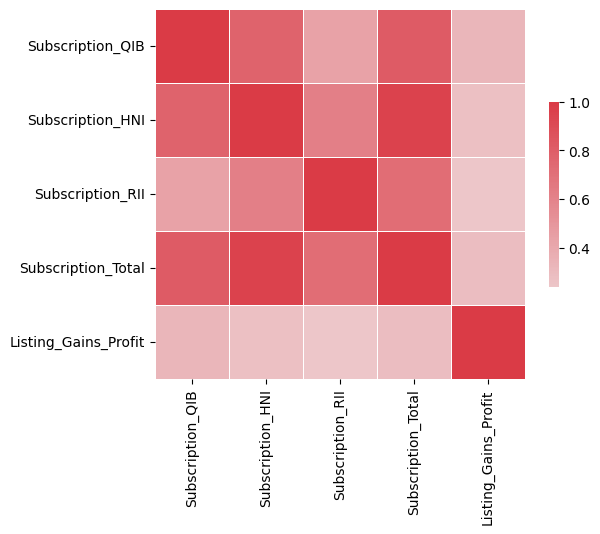

In [10]:
# Let's create a heatmap to see how our predictor and target variables correlate
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(df[['Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total', 'Listing_Gains_Profit']].corr(), cmap=cmap, vmax=1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})

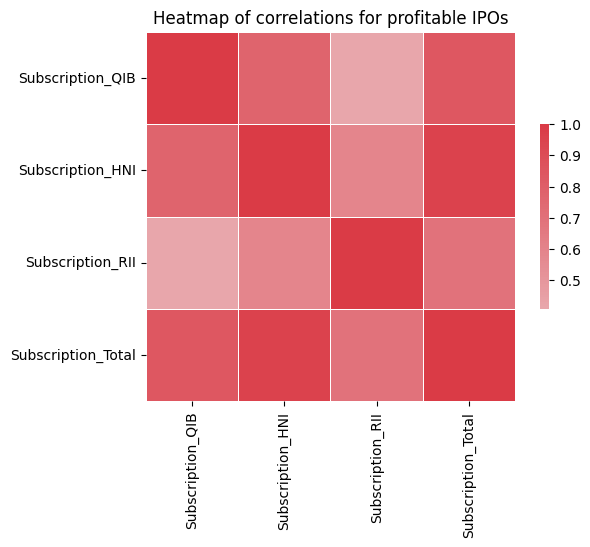

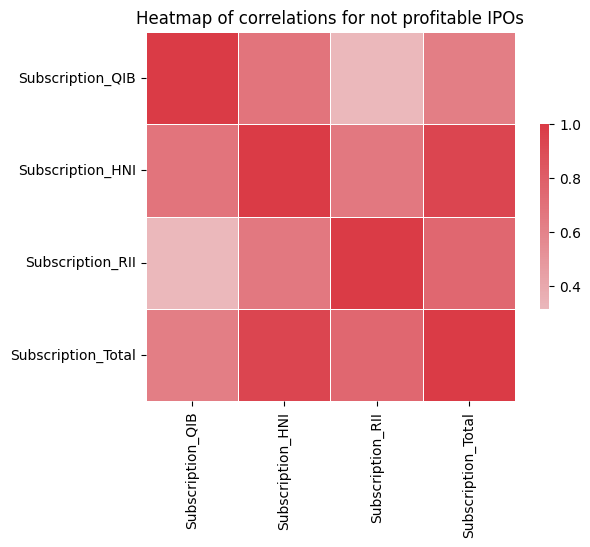

In [11]:
# In the same vein, I wonder how the correlations differ between outcome classes
profitable_df = df[df['Listing_Gains_Profit'] == 1]
not_profitable_df = df[df['Listing_Gains_Profit'] == 0]

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(profitable_df[['Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total']].corr(), cmap=cmap, vmax=1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of correlations for profitable IPOs')
plt.show()

cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(not_profitable_df[['Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total']].corr(), cmap=cmap, vmax=1, center=0,
                        square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Heatmap of correlations for not profitable IPOs')
plt.show()

In [12]:
# It's difficult to tell from the heatmap, so let's look at the numbers
print(profitable_df[['Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total']].corr())
print(not_profitable_df[['Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total']].corr())

                    Subscription_QIB  Subscription_HNI  Subscription_RII  \
Subscription_QIB            1.000000          0.769896          0.407021   
Subscription_HNI            0.769896          1.000000          0.587334   
Subscription_RII            0.407021          0.587334          1.000000   
Subscription_Total          0.838402          0.958021          0.692674   

                    Subscription_Total  
Subscription_QIB              0.838402  
Subscription_HNI              0.958021  
Subscription_RII              0.692674  
Subscription_Total            1.000000  
                    Subscription_QIB  Subscription_HNI  Subscription_RII  \
Subscription_QIB            1.000000          0.679831          0.315976   
Subscription_HNI            0.679831          1.000000          0.662222   
Subscription_RII            0.315976          0.662222          1.000000   
Subscription_Total          0.629869          0.941589          0.753048   

                    Subscription_

##### It looks like our profitable IPOs have a higher correlation between predictor variables than our not profitable IPOs, but not in all cases

([<matplotlib.axis.XTick at 0x7b9ac8f8b310>,
 [Text(0, 0, 'Not profitable'), Text(1, 0, 'Profitable')])

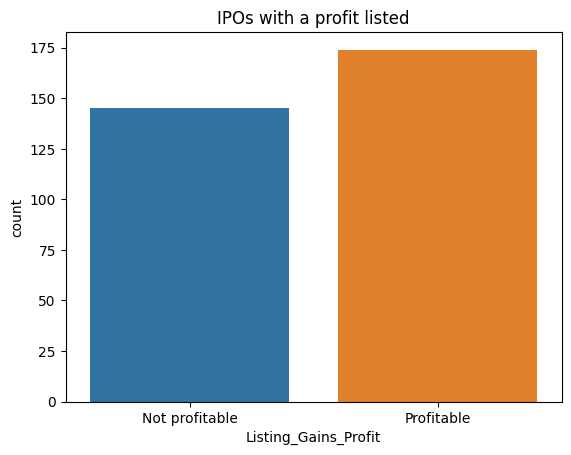

In [13]:
# Let's check out how our target is distributed
sns.countplot(data = df, x = 'Listing_Gains_Profit')
plt.title('IPOs with a profit listed')
plt.xticks(ticks= [0, 1],
           labels=['Not profitable', 'Profitable'])

In [14]:
# Checking for outliers in our predictor variables with .skew()
print(df['Subscription_QIB'].skew())
print(df['Subscription_HNI'].skew())
print(df['Subscription_RII'].skew())
print(df['Subscription_Total'].skew())

2.143704625584823
3.0784448213212667
3.7082740836630137
2.9119071381074786


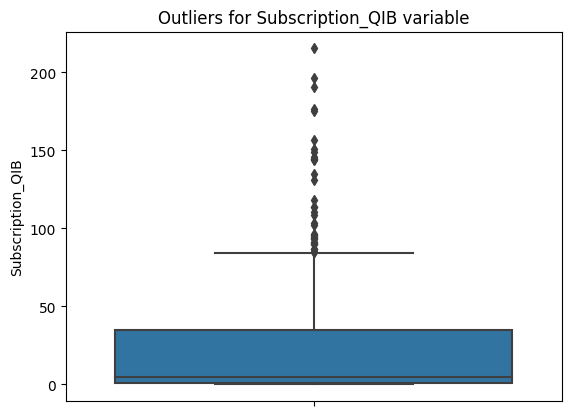

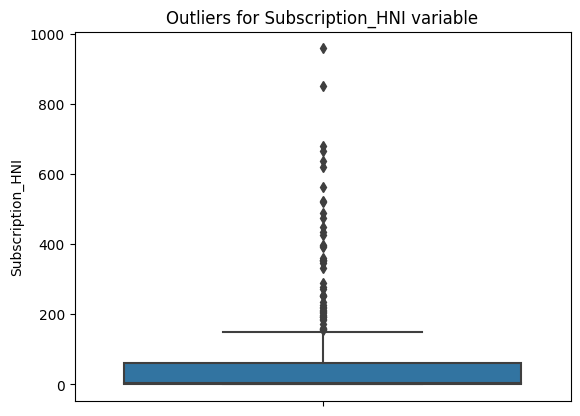

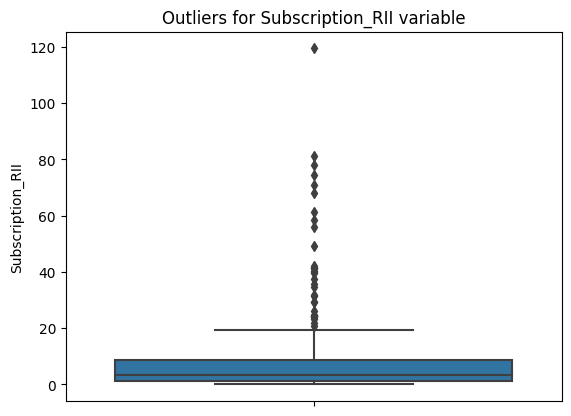

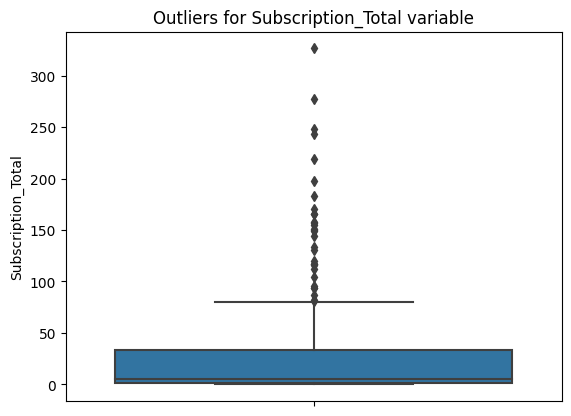

In [15]:
# The skew values are all higher than 1 indicating that there may be significant outliers. Let's take a closer look and see what we can find.
predictors = ['Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total']

for predictor in predictors:
    sns.boxplot(data = df, y = predictor)
    plt.title(f"Outliers for {predictor} variable")
    plt.show()

In [16]:
# It looks like we have a decent amount of outliers in each of the 4 predictor variables. Let's take a look to see how many we have.
for predictor in predictors:
    q1 = df[predictor].quantile(q=0.25)
    q3 = df[predictor].quantile(q=0.75)
    iqr = q3 - q1
    lower = (q1 - 1.5 * iqr)
    upper = (q3 + 1.5 * iqr)

    num_outliers = df[df[predictor] > upper].shape[0] + df[df[predictor] < lower].shape[0] # checking to see if there are any values below 0 for our subscription #s, which there are not
    print(f"Number of outliers for {predictor}: {num_outliers}.")

Number of outliers for Subscription_QIB: 35.
Number of outliers for Subscription_HNI: 48.
Number of outliers for Subscription_RII: 33.
Number of outliers for Subscription_Total: 31.


### In our EDA, we found:
    * There are a decent number of outliers for each of our predictor variables
    * About 54% of IPOs were listed as profitable
    * Profitable IPOs had a slightly higher correlation between their predictor variables than IPOs that were not profitable

## Data Cleaning

In [17]:
# Let's do something about these outliers by replacing the upper outliers with the upper bound of each variable
for predictor in predictors:
    q1 = df[predictor].quantile(q=0.25)
    q3 = df[predictor].quantile(q=0.75)
    iqr = q3 - q1
    lower = (q1 - 1.5 * iqr)
    upper = (q3 + 1.5 * iqr)

    df[predictor] = np.where(df[predictor] > upper, upper, df[predictor])

# Now let's check the number of outliers again
    print(df[df['Subscription_QIB'] > 84.86250000000001].shape[0])
    print(df[df['Subscription_HNI'] > 153.355].shape[0])
    print(df[df['Subscription_RII'] > 19.6].shape[0])
    print(df[df['Subscription_Total'] > 81.01999999999998].shape[0])

0
48
33
31
0
0
33
31
0
0
0
31
0
0
0
0


In [18]:
# Now that we've dealt with the outliers in our predictor variables, let's move on to officially setting our target and predictor variables and do some scaling

# create an array of the target variable
target_variable = ['Listing_Gains_Profit']

# create an array of the predictor variables
pred_list = list(set(list(df[predictors].columns)) - set(target_variable))

# scale the predictor variables between 0 and 1
df[pred_list] = df[pred_list] / df[pred_list].max()

# check to see if our scaling worked
df[pred_list].describe()

,Subscription_RII,Subscription_QIB,Subscription_HNI,Subscription_Total
count,319.000000,319.000000,319.000000,319.000000
mean,0.309232,0.253601,0.263157,0.252489
std,0.315147,0.342961,0.374477,0.335939
min,0.000000,0.000000,0.000000,0.000000
25%,0.065051,0.013551,0.008184,0.020304
50%,0.174490,0.058212,0.033061,0.060849
75%,0.439031,0.408131,0.404910,0.412182
max,1.000000,1.000000,1.000000,1.000000


In [19]:
# Using the holdout validation approach
X = df[pred_list].values
y = df[target_variable].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 47)
print(X_train.shape, X_test.shape)

(223, 4) (96, 4)


##### The deep learning classification model will be fit to the training set, and predictive ability will be assessed on the test set
##### Above, I've split the data into training and test sets with a 30% test size. I then confirmed the number of features and observations in each set

## Model Building And Evaluation

In [20]:
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(4, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.3783713210646056 -0.4273964089122897


In [21]:
# This will be the same style of model but with the ELU activation function
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'elu'))
model.add(tf.keras.layers.Dense(16, activation = 'elu'))
model.add(tf.keras.layers.Dense(8, activation = 'elu'))
model.add(tf.keras.layers.Dense(4, activation = 'elu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.18777217243000988 -0.24003850750861844


In [22]:
# This will be the same style of model but with a mix of ELU and ReLU activation functions
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(8, activation = 'elu'))
model.add(tf.keras.layers.Dense(4, activation = 'elu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.3257950310101023 -0.579314685272128


In [23]:
# My r2 scores still aren't great, so let's try a higher number of nodes
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.5935676665985314 -0.6537440721306826


In [24]:
# This will be the same style of model but with the ELU activation function
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'elu'))
model.add(tf.keras.layers.Dense(300, activation = 'elu'))
model.add(tf.keras.layers.Dense(100, activation = 'elu'))
model.add(tf.keras.layers.Dense(20, activation = 'elu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.09130972943180016 -0.11687568995203401


In [25]:
# This will be the same style of model but with a mix of ELU and ReLU activation functions
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'elu'))
model.add(tf.keras.layers.Dense(20, activation = 'elu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.6600109602595245 -0.7231452886782719


In [26]:
# Increasing the number of nodes certainly worked, so let's try an SGD optimizer
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.5)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.13586728698519823 -0.06919098468614471


In [27]:
# This will be the same style of model but with the ELU activation function
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'elu'))
model.add(tf.keras.layers.Dense(300, activation = 'elu'))
model.add(tf.keras.layers.Dense(100, activation = 'elu'))
model.add(tf.keras.layers.Dense(20, activation = 'elu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.5)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 2ms/step
0.09471648332175797 0.1311885789723065


In [28]:
# This will be the same style of model but with a mix of ELU and ReLU activation functions
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'elu'))
model.add(tf.keras.layers.Dense(20, activation = 'elu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1, momentum = 0.5)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.08854832580341898 -0.10174633323019133


In [29]:
# Finally, let's try an RMSprop (Root Mean Square propagation) optimizer
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.1, rho = 0.8)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.5626443466168896 -0.6216944156097792


In [30]:
# This will be the same style of model but with the ELU activation function
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'elu'))
model.add(tf.keras.layers.Dense(300, activation = 'elu'))
model.add(tf.keras.layers.Dense(100, activation = 'elu'))
model.add(tf.keras.layers.Dense(20, activation = 'elu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01, rho = 0.8)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.1272836728518607 -0.1337853410249652


In [31]:
# This will be the same style of model but with a mix of ELU and ReLU activation functions
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'elu'))
model.add(tf.keras.layers.Dense(20, activation = 'elu'))
model.add(tf.keras.layers.Dense(1))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.01, rho = 0.8)

model.compile(loss = 'mae', metrics = 'mae', optimizer = optimizer)
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)
pred_test = model.predict(X_test)

r2_train = r2_score(y_train, pred_train)
r2_test = r2_score(y_test, pred_test)

print(r2_train, r2_test)

3/3 [==============================] - 0s 1ms/step
-0.05740506341161611 -0.019486587276862366


### After thinking about this some more, I realized I should consider trying a different loss function when compiling my models - one for binary classifications.
### Since my Adam optimizer above gave the best results, I'm going to attempt to use that optimizer first and see what kind of results I get.

In [32]:
# Adam optimizer, sigmoid activation function, BinaryCrossEntropy loss function, learning rate 0.1
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 1.0027 - accuracy: 0.6458


[1.0026775598526, 0.6458333134651184]

In [33]:
# Adam optimizer, sigmoid activation function, BinaryCrossEntropy loss function, learning rate 0.01
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 3ms/step - loss: 1.2887 - accuracy: 0.6667


[1.2886505126953125, 0.6666666865348816]

7/7 [==============================] - 0s 1ms/step


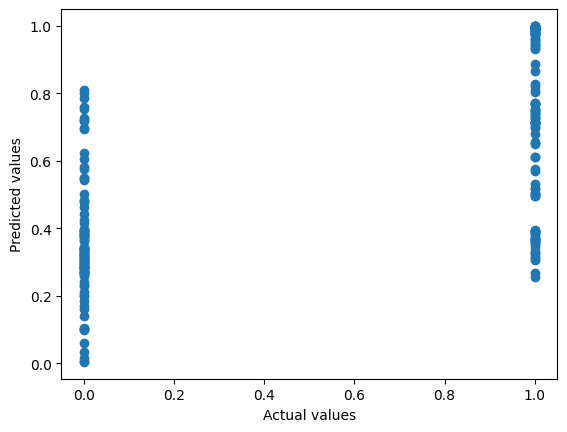

In [39]:
# Adam optimizer, sigmoid activation function, BinaryCrossEntropy loss function, learning rate 0.001
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(500, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(300, activation = 'relu'))
model.add(tf.keras.layers.Dense(100, activation = 'relu'))
model.add(tf.keras.layers.Dense(20, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

pred_train = model.predict(X_train)

plt.scatter(y_train, pred_train)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.show()

### My numbers above are looking pretty good, but just because I'm curious, I'm going to check to see what they look like with fewer nodes

In [35]:
# Adam optimizer, sigmoid activation function, BinaryCrossEntropy loss function, learning rate 0.1
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(4, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1)

model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.7371 - accuracy: 0.6354


[0.7371008992195129, 0.6354166865348816]

In [36]:
# Adam optimizer, sigmoid activation function, BinaryCrossEntropy loss function, learning rate 0.01
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(4, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01)

model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 1.3769 - accuracy: 0.6458


[1.376909613609314, 0.6458333134651184]

In [37]:
# Adam optimizer, sigmoid activation function, BinaryCrossEntropy loss function, learning rate 0.001
model = tf.keras.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation = 'relu'))
model.add(tf.keras.layers.Dense(8, activation = 'relu'))
model.add(tf.keras.layers.Dense(4, activation = 'relu'))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))

# Now I'll compile the model and pick an optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)

model.compile(optimizer = optimizer, loss = tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.fit(X_train, y_train, epochs = 150, verbose = 0)

# Let's evaluate our first attempt at a model
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.6019 - accuracy: 0.7083


[0.6019003391265869, 0.7083333134651184]

## Conclusion
#### I needed to take a break and think about this one for a bit before I figured out a way of improving my model. It makes sense to use a Binary Cross Entropy loss function here, since the value I'm trying to predict is a binary value! It also helped by changing my output layer in my model to 'sigmoid'.

#### I played around with all kinds of learning rates, optimizers, number of nodes and activation functions, but my 500-node models ended up having the best accuracy scores. Interestingly, as I decreased the learning rate on this model, my training accuracy went up while my test accuracy went slightly down:
##### Learning rate 0.1:
    ##### Train accuracy: 0.67, test accuracy: 0.65
##### Learning rate 0.01:
    ##### Train accuracy: 0.79, test accuracy: 0.67
##### Learning rate 0.001:
    ##### Train accuracy: 0.83, test accuracy: 0.64
    
#### I'm slightly concerned about overfitting with this model since the train and test accuracies got further apart as I decreased the learning rate. I think that I could definitely optimize this model more if I play around with it.